# Наумкин Владимир, С01-119.

## Задача 5. Генерация аннотации к изображению.

Будем использовать код https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning.

### Подключим библиотеки

In [1]:
import nltk
import pickle
from collections import Counter
from pycocotools.coco import COCO

import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import numpy as np
from PIL import Image

import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

### Уберём предупреждения

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Зададим устройство исполнения кода (вычисления провожу на своём ПК)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Скачаем датасет вручную, по аналогии со скриптом download.sh

http://images.cocodataset.org/annotations/annotations_trainval2014.zip

http://images.cocodataset.org/zips/train2014.zip

http://images.cocodataset.org/zips/val2014.zip

Распакуем скачанные файлы в папку data

### Построим словарь

In [4]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(json, threshold, limit = None):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    if limit is not None:
        ids = list(ids)[:limit]
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [5]:
#После выполнения закомментированного ниже кода загрузим полученный словарь (перезапустим клетку, чтобы убрать print)

vocab_path = './data/vocab.pkl'
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
"""
#nltk.download('punkt_tab') # была ошибка, нужно было докачать библиотеку по сути

vocab = build_vocab(json = './data/annotations/captions_train2014.json', threshold = 3, limit = 10000) # Ограничим выборку
vocab_path = './data/vocab.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))
"""

'\n#nltk.download(\'punkt_tab\') # была ошибка, нужно было докачать библиотеку по сути\n\nvocab = build_vocab(json = \'./data/annotations/captions_train2014.json\', threshold = 3, limit = 10000) # Ограничим выборку\nvocab_path = \'./data/vocab.pkl\'\nwith open(vocab_path, \'wb\') as f:\n    pickle.dump(vocab, f)\nprint("Total vocabulary size: {}".format(len(vocab)))\nprint("Saved the vocabulary wrapper to \'{}\'".format(vocab_path))\n'

### Изменим размер картинок

In [6]:
def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.LANCZOS)

def resize_images(image_dir, output_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_images, output_dir))

In [7]:
#Аналогично после выполнения строки ниже закомментируем её и перезапустим клетку
#resize_images('./data/train2014/', './data/resized2014/', [256, 256])

### Функции для работы с датасетом

In [8]:
class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None, limit = None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform
        #Ограничиваем размер выборки
        if limit is not None:
            self.ids = self.ids[:limit]

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)


def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.

    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.

    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

def get_loader(root, json, vocab, transform, batch_size, shuffle, limit = None):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco = CocoDataset(root=root,
                       json=json,
                       vocab=vocab,
                       transform=transform,
                       limit = limit)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=coco, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_fn)
    return data_loader, len(coco)

## Модель

In [9]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, vocab_size, embed_size = 256, hidden_size = 512, num_layers = 1, max_seq_length = 20):
        super(type(self), self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers, max_seq_length)
    
    def forward(self, images, captions, lengths):
        return self.decoder(self.encoder(images), captions, lengths)

### Генерация описания по картинке

In [11]:
def load_image(image_path, transform = True):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    if transform:
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406),
                                                             (0.229, 0.224, 0.225))])
        image = transform(image).unsqueeze(0)
    return image

In [12]:
def describe_images(vocab, model, images):
    num_images = len(images)
    model.eval()
    texts = []
    for i in range(num_images):
        image = images[i]
        image_tensor = image.to(device)
        # Generate an caption from the image
        feature = model.encoder(image_tensor)
        sampled_ids = model.decoder.sample(feature)
        sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
        # Convert word_ids to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            sampled_caption.append(word)
            if word == '<end>':
                break
        description = ' '.join(sampled_caption)
        texts.append('Картинка ' + str(i + 1) + ': ' + description)
    return texts

In [13]:
def show_images(images):
    num_images = len(images)
    fig = plt.figure(figsize=(15, 5 * (num_images // 3 + 1)))
    for i in range(num_images):
        image = images[i]
        ax = fig.add_subplot((num_images // 3) + 1, 3, i + 1)
        ax.imshow(image)
        ax.set_title('Картинка ' + str(i + 1))
        ax.axis('off')
    plt.tight_layout()
    return fig

In [14]:
images_paths = ['./data/val2014/COCO_val2014_000000004509.jpg',
                './data/val2014/COCO_val2014_000000006662.jpg',
                './data/val2014/COCO_val2014_000000007789.jpg']
my_images = [load_image(i) for i in images_paths]
orig_images = [load_image(i, False) for i in images_paths]

In [15]:
def nice_check(vocab, model, my_images, orig_images):
    texts = describe_images(vocab, model, my_images)
    fig = show_images(orig_images)
    plt.show()
    for s in texts:
        print(s)

### Код для обучения модели

In [16]:
def trainer(count_of_epoch, 
            batch_size, 
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None,
            limit = None):

    optima = optimizer(model.parameters(), lr=lr)
    
    # Image preprocessing, normalization for the pretrained resnet
    transform = transforms.Compose([ 
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    data_loader, len_dataset = get_loader('./data/resized2014', './data/annotations/captions_train2014.json',
                                          vocab, transform, batch_size, True, limit)
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            data_loader, 
            leave=False, total=len_dataset//batch_size+(len_dataset%batch_size> 0))
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

In [17]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (images, captions, lengths) in enumerate(train_generator):
        batch_loss = train_on_batch(model, images, captions, lengths, optimizer, loss_function)
        if callback is not None:
            with torch.no_grad():
                callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(images)
        total += len(images)
    
    return epoch_loss/total

In [18]:
def train_on_batch(model, images, captions, lengths, optimizer, loss_function):
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
    model.train()
    optimizer.zero_grad()
    outputs = model(images, captions, lengths)
    loss = loss_function(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.cpu().item()

In [19]:
class callback():
    def __init__(self, writer, loss_function, delimeter = 100, batch_size = 64, limit = None):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.limit = limit

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)
        
        if self.step % self.delimeter == 0:
            # Image preprocessing, normalization for the pretrained resnet
            transform = transforms.Compose([ 
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(), 
                transforms.ToTensor(), 
                transforms.Normalize((0.485, 0.456, 0.406), 
                                     (0.229, 0.224, 0.225))])
            batch_generator, len_dataset = get_loader('./data/resized_val2014', './data/annotations/captions_val2014.json',
                                                      vocab, transform, self.batch_size, True, self.limit)
            
            test_loss = 0
            model.eval()
            for it, (images, captions, lengths) in enumerate(batch_generator):
                images = images.to(device)
                captions = captions.to(device)
                targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
                output = model(images, captions, lengths)

                test_loss += self.loss_function(output, targets).cpu().item()*len(images)
            
            test_loss /= len_dataset
            
            self.writer.add_scalar('LOSS/test', test_loss, self.step)
            texts = describe_images(vocab, model, my_images)
            text = '\n'.join(texts)
            self.writer.add_text('DESCRIPTION/test', text, self.step)
          
    def __call__(self, model, loss):
        return self.forward(model, loss)

In [20]:
#Не забудем обработать картинки для валидации и закомментировать print
#resize_images('./data/val2014/', './data/resized_val2014/', [256, 256])

### Обучение

In [21]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

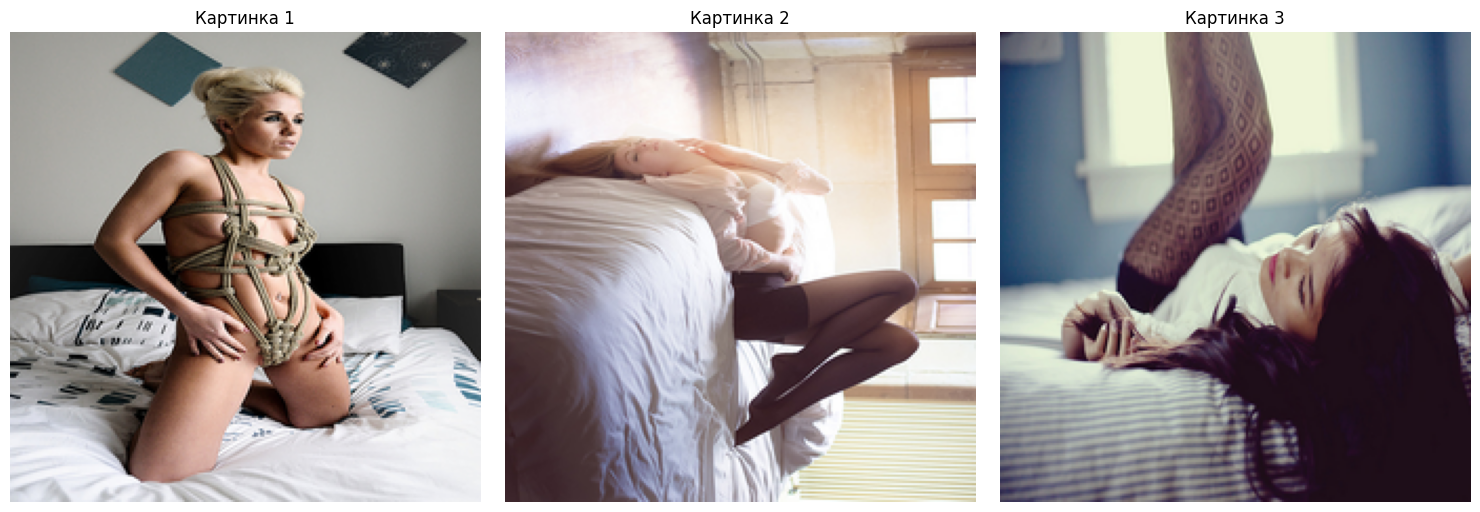

Картинка 1: sits closeup sprinkles kids bikes scooter where skate july island read monitor blonde poles second still also was fixtures also
Картинка 2: sits eyes near still also bucket tray brushing sloped lush viewed carrier nuts panel cats interior a weather weather utilizes
Картинка 3: chandelier suburban still recipe haired cars gold trees pictured work chefs hung ribbon bay oranges chefs hung soup cycle chocolate
loading annotations into memory...
Done (t=0.75s)
creating index...
index created!


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


  0%|          | 0/157 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


  0%|          | 0/157 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


  0%|          | 0/157 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


  0%|          | 0/157 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


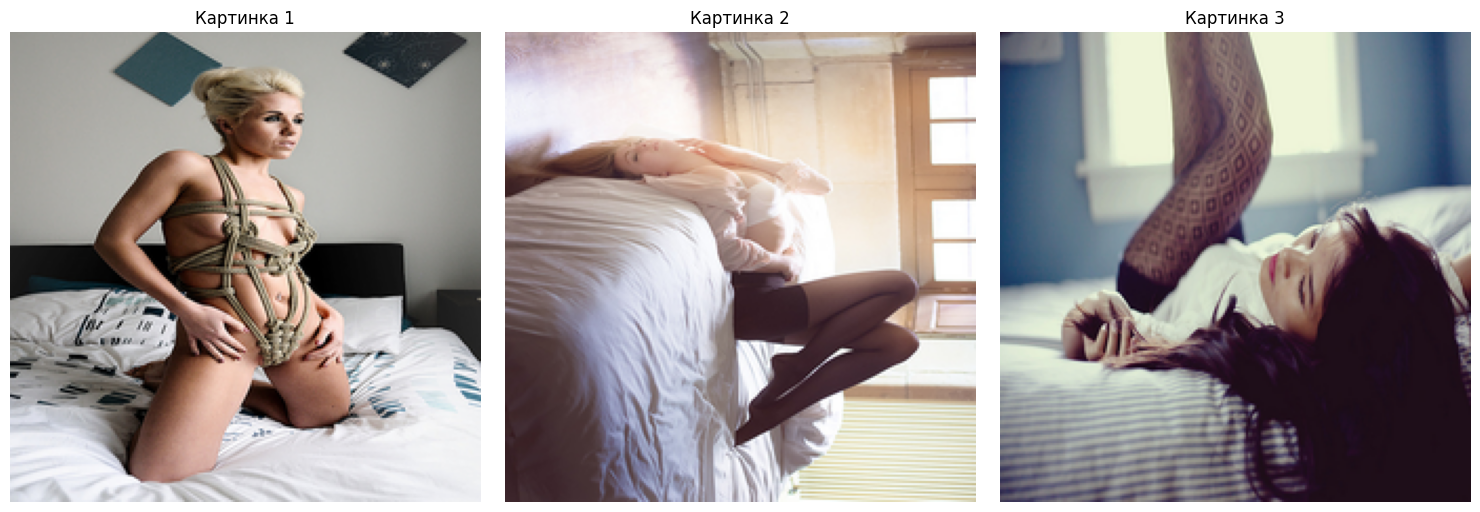

Картинка 1: <start> a man is holding a banana in the air . <end>
Картинка 2: <start> a cat is sitting on a toilet in a bathroom . <end>
Картинка 3: <start> a cat is sitting in a car with a cat on the back of a car . <end>


In [22]:
writer = SummaryWriter(log_dir = f'tensorboard5/reduced_dataset')
call = callback(writer, loss_function, delimeter = 50, batch_size = 64, limit = 5000) # Ограничим тестовую выборку
model = Autoencoder(len(vocab)).to(device)
nice_check(vocab, model, my_images, orig_images)
trainer(count_of_epoch=5,
        batch_size=64,
        model=model,
        loss_function=loss_function,
        optimizer = optimizer,
        lr = 0.001,
        callback = call,
        limit = 10000) # Ограничим тренировочную выборку
nice_check(vocab, model, my_images, orig_images)

Сохраним текущее состояние модели

In [23]:
torch.save(model.state_dict(), './data/model_reduced_dataset.pkl')

Код, чтобы загрузить с нуля

In [24]:
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_path = './data/vocab.pkl'
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
model = Autoencoder(len(vocab)).to(device)
model.load_state_dict(torch.load('./data/model_reduced_dataset.pkl'))
"""

'\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nvocab_path = \'./data/vocab.pkl\'\nwith open(vocab_path, \'rb\') as f:\n    vocab = pickle.load(f)\nmodel = Autoencoder(len(vocab)).to(device)\nmodel.load_state_dict(torch.load(\'./data/model_reduced_dataset.pkl\'))\n'

## Выводы

In [25]:
len(vocab)

1840

Даже при тренировке на ограниченном датасете модель попыталась дать описание картинок с девушками. Конечно, вышло не очень, но и так каждая эпоха обучения занимала примерно 1.5 часа. Причём на полном датасете эпоха длилась бы больше суток.

### Дополнительные выводы после просмотра tensorboard

Функция потерь начала выходить на константу, то есть 5 эпох как раз было достаточно при выбранной конфигурации модели и датасета. В промежуточных описаниях картинок несколько раз попалось слово woman, но преобладали слова man, cat, toilet, bathroom. Скорее всего, причиной этому является ограниченная тренировочная выборка, а я выбрал специфичные тестовые фото.

# P.S.

Ниже представлен полный вариант кода для загрузки предобученной модели и пример её работы. Первые 3 картинки совпадают с тестовыми фото девушек (см. выше - доказательство того, что загружена именно модель, обученная мною). Далее фото нашего взвода с военной кафедры после экскурсии - получилось на удивление точное описание. Потом взятая из интернета картинка кота, лежащего в раковине - раз уж модель обычно пытается выдать именно это. Наконец, тоже загруженное из интернета фото мужчины за рулём автомобиля, смотрящего через опущенное стекло двери машины.

Сами фото тут не стал отображать, так что их покажу при очной сдаче.

In [3]:
import torch
import pickle
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import warnings

def main():
    global_path = './data/'
    vocab_path = global_path + 'vocab.pkl'
    model_path = global_path + 'model_reduced_dataset.pkl'
    images_count = 6
    images_paths = [global_path + str(i + 1) + '.jpg' for i in range(images_count)]
    
    warnings.filterwarnings("ignore")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    model = Autoencoder(len(vocab)).to(device)
    model.load_state_dict(torch.load(model_path))
    nice_check(vocab, model, images_paths, device)

class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]
    def __len__(self):
        return len(self.word2idx)

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained = False)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids

class Autoencoder(nn.Module):
    def __init__(self, vocab_size, embed_size = 256, hidden_size = 512, num_layers = 1, max_seq_length = 20):
        super(type(self), self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers, max_seq_length)
    def forward(self, images, captions, lengths):
        return self.decoder(self.encoder(images), captions, lengths)

def load_image(image_path, transform = True):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    if transform:
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406),
                                                             (0.229, 0.224, 0.225))])
        image = transform(image).unsqueeze(0)
    return image

def describe_images(vocab, model, images, device):
    num_images = len(images)
    model.eval()
    texts = []
    for i in range(num_images):
        image = images[i]
        image_tensor = image.to(device)
        feature = model.encoder(image_tensor)
        sampled_ids = model.decoder.sample(feature)
        sampled_ids = sampled_ids[0].cpu().numpy()
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            sampled_caption.append(word)
            if word == '<end>':
                break
        description = ' '.join(sampled_caption)
        texts.append(description)
    return texts

def nice_check(vocab, model, images_paths, device):
    my_images = [load_image(i) for i in images_paths]
    texts = describe_images(vocab, model, my_images, device)
    for i in range(len(texts)):
        print(images_paths[i] + ": " + texts[i])

if __name__ == "__main__":
    main()

./data/1.jpg: <start> a man is holding a banana in the air . <end>
./data/2.jpg: <start> a cat is sitting on a toilet in a bathroom . <end>
./data/3.jpg: <start> a cat is sitting in a car with a cat on the back of a car . <end>
./data/4.jpg: <start> a group of people are standing in front of a building . <end>
./data/5.jpg: <start> a cat is sitting in a bathroom with a toilet . <end>
./data/6.jpg: <start> a man is sitting on a bench in the middle of a car . <end>
